### This code will merge patches with the central_tendency method and upscale with bicubic interpolation

In [1]:
import os
import glob

import skimage
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from shutil import copyfile

from shutil import copytree
from shutil import rmtree

from supreshelper import *

In [2]:
data_path = "Data/"
data_generated = "DataGenerated"

train = glob(data_path +  "train/*/*") 
test = glob(data_path + "test/*/*") 

In [3]:
print(len(train), len(test))

1160 290


# Count max number of LRs

In [4]:
max_lrs = 0
for scene in glob(data_path + "train/*/*") + glob(data_path + "test/*/*"):
    lrs = len(glob(scene + "/LR*"))
    if max_lrs < lrs:
        max_lrs = lrs
        print(scene)

print(max_lrs)

Data/train/RED/imgset0486
Data/train/RED/imgset0291
Data/train/RED/imgset0429
Data/train/RED/imgset0319
35


# Generate singe image

In [5]:
def mergeAndUpscale(scene_path):
    merged = central_tendency(scene_path, agg_with='median', only_clear=False)
    return bicubic_upscaling(merged)

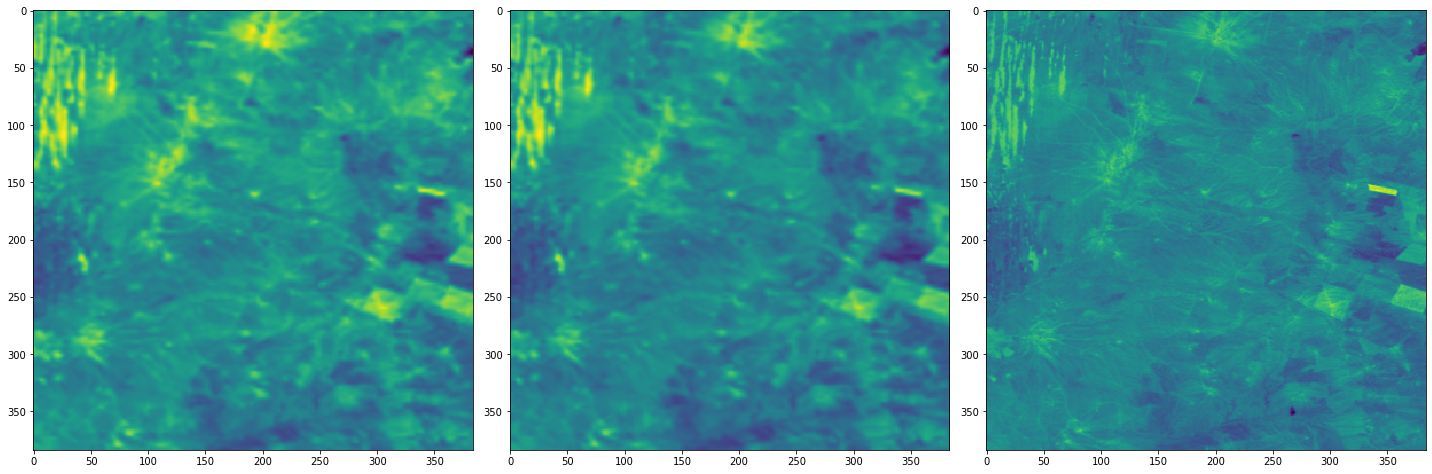

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,3,1)
plt.imshow(mergeAndUpscale(train[1]))

ax = fig.add_subplot(1,3,2)
plt.imshow(baseline_upscale(train[1]))
 
ax = fig.add_subplot(1,3,3)
plt.imshow(highres_image(train[1])[0])

plt.tight_layout()

In [7]:
def array_to_tfrecords_single(all_, output_file):
    feature ={ "all": tf.train.Feature(float_list=tf.train.FloatList(value=all_.flatten()))}
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()

    writer = tf.io.TFRecordWriter(output_file)
    writer.write(serialized)
    writer.close()

In [8]:
def array_to_tfrecords_multiple(lrs, hr, output_file):
    feature ={"lrs": tf.train.Feature(float_list=tf.train.FloatList(value=np.concatenate(lrs).ravel())),
              # We don't need the list length after deciding to use a fixed length now
              #"lrs_length": tf.train.Feature(int64_list=tf.train.Int64List(value=[len(lrs)])),
              "hr": tf.train.Feature(float_list=tf.train.FloatList(value=hr.flatten())),
             }
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()

    writer = tf.io.TFRecordWriter(output_file)
    writer.write(serialized)
    writer.close()

In [9]:
# TODO could make parallelizable
def saveScene(scene_path):
    new_path = data_generated + "/" + "/".join(scene_path.split("/")[1:])
    os.makedirs(new_path, exist_ok=True)
    
    LR_up = mergeAndUpscale(scene_path)
    lr_filler = central_tendency(scene_path, agg_with='median', only_clear=False)
    
    lrs = []
    for lr,_ in lowres_image_iterator(scene_path):
        lrs.append(lr)
        
    # Fill the list with the median of all LR to reach the max amount
    for i in range(0, max_lrs - len(lrs)):
        lrs.append(lr_filler)
    
    # Shuffle the list randomly
    random.shuffle(lrs)
    
    SM = skimage.img_as_float64(skimage.io.imread(scene_path + "/" + 'SM.png'))
    
    if scene_path.split("/")[1] == "train":
        HR = skimage.img_as_float64(skimage.io.imread(scene_path + "/" + 'HR.png'))
        array_to_tfrecords_single(np.concatenate([LR_up, HR, SM], axis=1), new_path + "/" + "single.tfrecords")
        array_to_tfrecords_multiple(lrs, np.where(SM > 0, HR, np.NaN), new_path + "/" + "multiple.tfrecords")
        
    else:
        array_to_tfrecords_single(LR_up, new_path + "/" + "single.tfrecords")
        array_to_tfrecords_multiple(lrs, np.ones([384,384]), new_path + "/" + "multiple.tfrecords")
    
    for f in glob(scene_path+ "/*"):
        copyfile(f,  data_generated + "/" + "/".join(f.split("/")[1:]))

In [10]:
for scene in train + test:
    saveScene(scene);

### Move 30 random scenes to the dev directory for validation

In [11]:
for scene in random.sample(glob(data_generated +  "/train/*/*"), 30):
    
    scene_elem = scene.split("/")
    dst = data_generated + "/dev/" + "/".join(scene_elem[2:])
    copytree(scene, dst)
    rmtree(scene)